This script mainly concerns the computation of:
- Contingency table:
    - Presented in the form of a confusion matrix, it displays the total amounts of land use transitions between two maps. Specifically, it sums up which cells from base year remained the same and which transitioned. Thus it provides information on land use inertia, and, in the case of a state change, which are the most likely transitions.

- Enrichment factors:
    - Evaluates the neighborhood of all cells that changed state in search for a surrounding land use composition that might explain such change. For example, if there's a change from residential to retail/services, it looks in the neighborhood for land uses that are over or under represented when compared to the average cell.
    
Those quantities are input of the initiation values of the neighborhood effects.

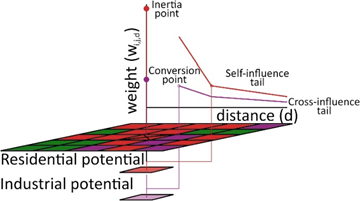

***The above quantities need only be computed for the base year, on the one hand, and the calibration year, on the other, that is, 2011 and 2017.***

In [1]:
import fiona
import h3
import os
import pathlib
import re
import warnings
    
import contextily as cx
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from time import perf_counter


%matplotlib inline
%config InlineBackend.figure_format='retina'

# Preliminaries

In [2]:
db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)

In [3]:
map_res = 11

The following functions are meant to read the hexagons for the base, calibration and validation years.

The land uses and categories are turned into categoricals and a relative order is imposed, albeit it does not have any intrinsic meaning, it mainly serves data presentation purposes. 

Also, whatever hexagons with null values are dropped. At this stage, there should only be nulls at the Pampulha Lagoon region and in cells that perfectly coincide with carriageways, which thus do not touch any land use polygons. It seems reasonable enough to simply ignore those in the model. In the future, I might consider inputting whichever is the proedominant use in the neighborhood. For now, I'll just drop nan records

In [4]:
def _get_path_to_gpkg(res):
    # TO DO: allow for more flexibility in the naming of the file?
    re_path = r'(BH_)(hex_\d{1,2})(_with_land_uses\.gpkg)'

    for file in (out_folder / 'A').iterdir():
        match = re.search(re_path, file.name)
        # If there's no search result, match is None
        if match:
            # The gdf in each layer was indexed by a H3 label,
            # and the index name corresponded to the hex resolution.
            # When saving to geopackage, the index name is lost.
            # This parameter takes the info on resolution from the
            # file to later insert it back to the data
            hex_res = match.group(2) # .group() is one-indexed
            
            if hex_res == f'hex_{res}':
                return file, hex_res


def _get_hexagons_with_uses(path, layername, hex_resolution):
    # The following is just because Fiona is emmiting an annoying
    # warning message that is most likely useless (see link for
    # this issue below)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                category=RuntimeWarning,)
        hex_ = gpd.read_file(path, layer=layername)
        
    hex_['year'] = layername
    
    
    return hex_.rename(columns={'index': hex_resolution})


def _drop_nulls(gdf, hex_res):
    nulls = gdf.loc[gdf.use.isnull(), hex_res].unique()
    
    
    return gdf.loc[~gdf[hex_res].isin(nulls)]
    


def _enforce_preferred_order(data):
    categoricals = {
        'category': ['active', 'passive', 'static'],
        
        'use': ['residential', 'subnormal', 'retail/services',
                'mixed', 'vacant', 'amenities', 'public services',
                'industry', 'infrastructure']
                   }
    
    for each in ['category', 'use']:
        data[each] = pd.Categorical(data[each],
                                    categories=categoricals[each],
                                    ordered=True,)
        
        
    return data.sort_values(['category', 'use'])


def get_land_use_maps(res):
    """Reads geopackage containing land use maps for 
    each study year. It assumes one year per layer and
    that each year has the same structure.
    """
    path, hex_res =  _get_path_to_gpkg(res)
    
    hex_series = []
    for layername in fiona.listlayers(path):
        hex_series.append(_get_hexagons_with_uses(path, layername, hex_res))
        
    hexes = pd.concat(hex_series, ignore_index=True)
    hexes = _enforce_preferred_order(hexes)
    hexes = _drop_nulls(hexes, hex_res)
    hexes.set_index(hex_res, inplace=True)
    hexes.index.name = hex_res
    
    return hexes

https://github.com/Toblerity/Fiona/issues/986

In [5]:
hexes = get_land_use_maps(map_res)

hexes.head(3)

,pop,income,x_epsg31983,y_epsg31983,category,use,geometry,year
hex_11,,,,,,,,
8ba881ac9332fff,24.553798,1729.860000,614971.548709,7.797884e+06,active,residential,"POLYGON ((614986.036 7797858.452, 615002.006 7...",2011
8ba88cd842dcfff,30.170992,1013.356197,605947.189537,7.799072e+06,active,residential,"POLYGON ((605965.637 7799044.839, 605981.596 7...",2011
8ba88cdb244cfff,24.630182,2177.399819,613752.435148,7.796814e+06,active,residential,"POLYGON ((613765.667 7796788.587, 613781.634 7...",2011


# Land Coverage by Use

In [6]:
def _get_palette(which):
    category_palette = {'active': '#C97064',
                        'static': '#39487F',
                        'passive': '#527048',}
    
    use_palette = {'residential': '#FC9CE3',
                   'subnormal': '#B05F66',
                   'retail/services': '#3B727C',
                   'mixed': '#60E1E0',
                   'vacant': '#82A775',
                   'industry': '#291A10',
                   'infrastructure': '#FFF185',
                   'public services': '#A85118',
                   'amenities': '#7D573C',}

    if which == 'category':
        return category_palette
    if which == 'use':
        return use_palette

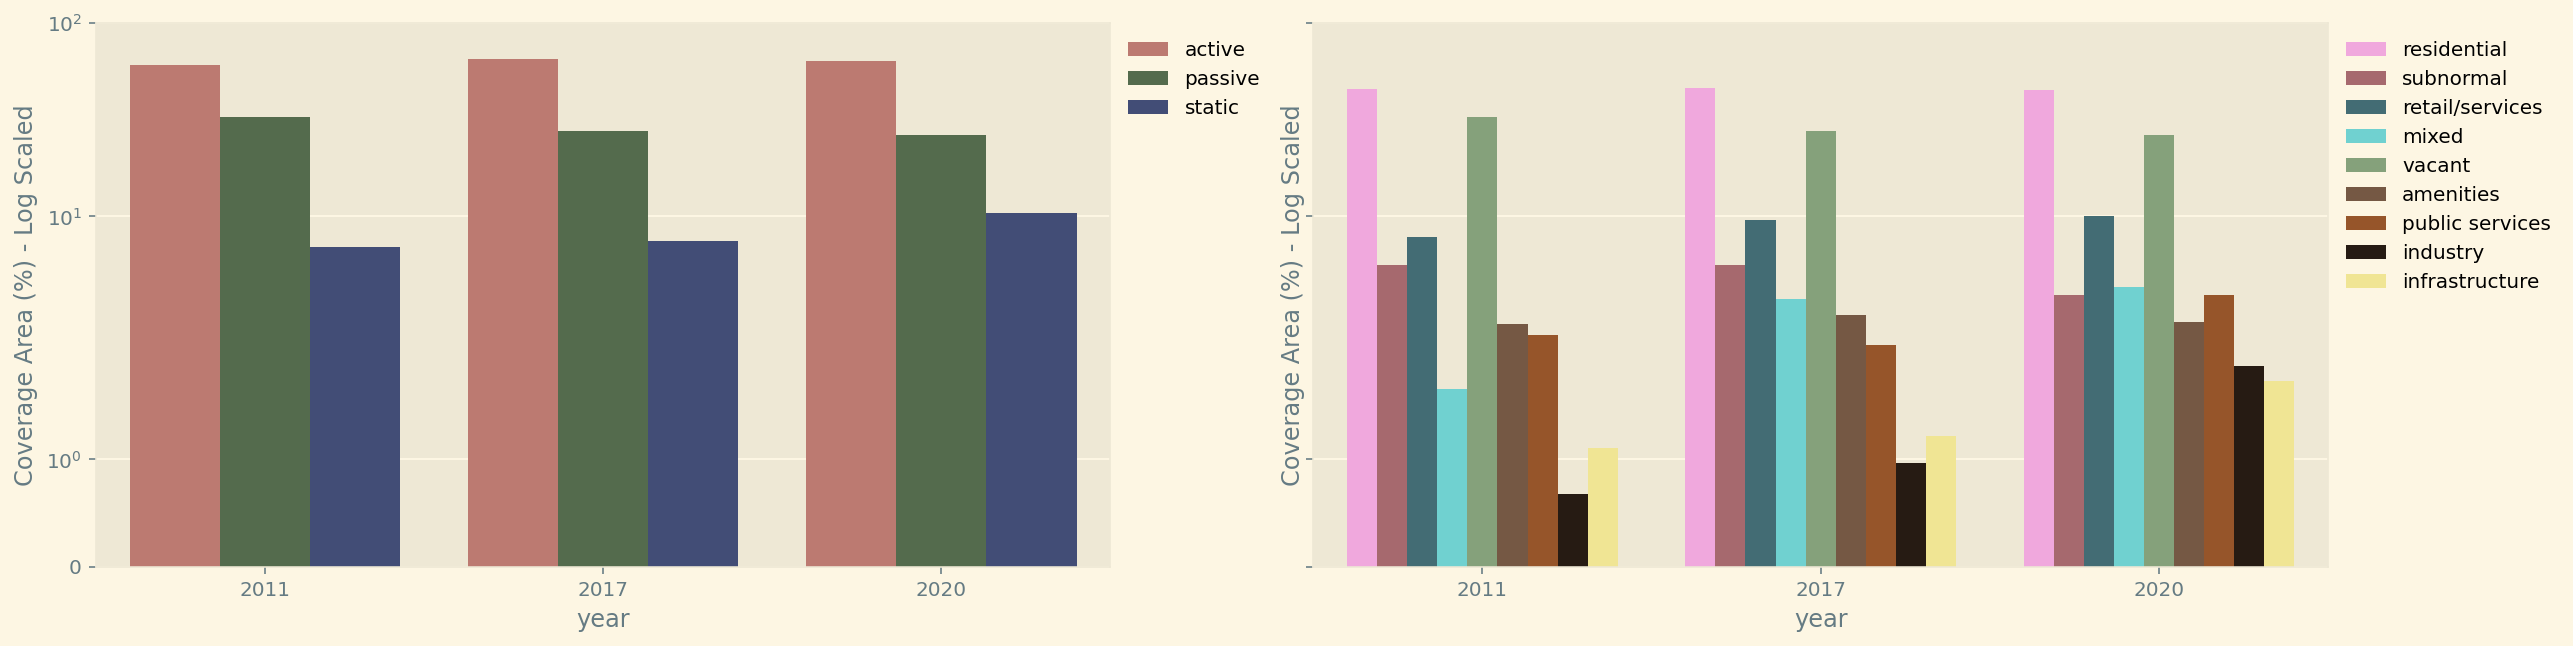

In [7]:
def _get_lu_coverage(gdf, lu_col, total_cells):
    def _pct_by_use(col):
        return len(col) / total_cells * 100
    gdf['pct'] = 1
    
    return (pd.pivot_table(gdf,
                           index=['year', lu_col],
                           aggfunc=_pct_by_use)
              .pct
              .reset_index())


def summarize_land_use_extentions(gdf):
    """The number of cells in the study area is constant
    in each map, the only thing that changes is their composition.
    Thus, this function plots the relative number of cells that
    each land use occupies.
    """
    plt.style.use('Solarize_Light2')
    f, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)
    
    # TO DO: consider inserting a check to ensure that each
    # year has the same number o cells. They should.
    total_cells = len(gdf) / 3
    for i, each in enumerate(['category', 'use']):
        areas = _get_lu_coverage(gdf, each, total_cells)
        
        ax = axes[i]
        sns.barplot(data=areas,
                    x='year',
                    y='pct',
                    hue=each,
                    palette=_get_palette(each),
                    ax=ax)
        
        ax.legend(bbox_to_anchor=(1,1),
                  loc='upper left',
                  frameon=False)
        
        ax.set_ylabel('Coverage Area (%) - Log Scaled')
        ax.set_ylim(bottom=0, top=100)
        ax.set_yscale('symlog')
        
    gdf.drop(columns='pct', inplace=True)

        
summarize_land_use_extentions(hexes)

In [8]:
hexes.groupby(['use', 'year']).apply(len).unstack().T.pct_change() 

use,residential,subnormal,retail/services,mixed,vacant,amenities,public services,industry,infrastructure
year,,,,,,,,,
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,0.013217,0.004389,0.225136,1.255124,-0.151092,0.118061,-0.106603,0.435155,0.097593
2020,-0.021715,-0.300129,0.049220,0.162444,-0.047212,-0.077156,0.801458,0.931292,0.417902


# Empirical Measures

This section computes the three empirical measures utilized by Newland et al. (2011)⁕ to initiate the calibration procedure. They reflect the interactions between the land uses in the neighborhood and their intrinsic transition characteristics.

It should be noted that even though some convertions do happens, they are not allowed in the model dynamics. That is, ***public*** and ***industry*** categories are supposed to be fixed and changes in those between 2011 and 2017 are attributed to either top down decisions - not strictily tied to (local) city dynamics - or to errors in parcel classification during the construction of the land use maps. The latter are most propbably caused by two reasons. First and foremost, the source maps themselves, as provided by BH city hall are not perfect, as that would require that all raw databases used in the making of those maps were both perfectly complete and perfectly compatible. That, of course, is not the case. On top of that, my own imputation scheme could lead to some imprecisions. For example, when a hexagon intersected with more than one land use, it would receive the state of the one which occupied most of its area, not to mention the assumptions I made for parcels with no information.

That does not mean that some of the transitions observed for other uses cannot be attributed to the reasons above, but it should be safe to assume that most of them are more strongly connected with local dynamics. In light of all that, I will ignore industrial and public land when computing the quantities below.

The inputation process resulted into some leftover NaN cells, which happen mostly when hexagons are directly over roads. That is, the original land use maps do not contain polygons in the streets, hence there is nothing to input in a hexagon that lies directly on streets.

⁕ https://doi.org/10.1016/j.envsoft.2018.07.013

***A Note on the Enrichment Factors***

Before defining the enrichment factor, the neighborhood must be defined in more precise terms. Usually the literature defines the neighborhood in terms of the number of cells in each direction, therefore, the extension of a neighborhood will ultimately depend on the number of cells the neighborhood contains and on their dimensions. That means that including more cells of a smaller dimensions is, in some ways, the same as working with less cells of coarser resolution.

I chose to work with absolute terms instead: any given cell will be included in the neighborhood of hexagon *h* based on a distance threshold. Inspired by the paper of Hidalgo et al (2020), that threshold is set to 500 m - as the crow flies. The authors found that this distance formed meaningful amenity clusters in their model, while also being consistent with a 10 min pedestrian trip. The authors modeled a small sample of american cities, and if their method is replicated elsewhere it might lead to different results. Nevertheless, I'll take this threshold as given, for the time being. After all, I can think of no reason why such a threshold would be largely different.

At the same time we will adapt the approach of Newland, Zecchin, et al. (2018). These authors reduced the number of reference points in the neighborhood, so as to reduce the cimputational complexity of the calibration process. They represented the influence tail by three reference points, with a linear decay in between:
- Influence value of a cell at distance d = 1 is derived from the enrichment factor
- At distance two, a value that is 10% that of point one
- At distance 5, influence decays to zero

In that way there's only one parameter for calibration. That reduces computational costs, but it is a clear simplification of the processes in study. Later analysis might consider a relaxation of this approach.

Distances in Newland, Zecchin, et al. (2018) were in terms of cells - i.e. distance 5 is five cells away from the central one. That needs to be slightly adjusted for my case, in which I deal with absolute distances. For that, I'll split the 500m into three distance bands:
- 0 to 100m
- 100 to 200m
- 200 to 500m

Consequently, it is the enrichment factor of this first band that will be used to initiate the calibration of the influence tails. As for the distance decay, this initial value is assumed to be located right next to the central cell. In turn, the second key point should be at the border between the first and second bands, and, finally, the last point is at 500m, where the influence decays to zero.

There is however the computational cost of calculating the neighborhood. At first, I thought of libpysal, but that resulted in <MemoryError: bad allocation>. Hence, I used H3's neighborhood functions, which are relative to a k-ring distance. Therefore, I will convert the distance bands above to the equivalent distance in number of H3 hexagons and, for that I will use the hexagon's apothem. In the case of resolution 12, for instance, that would resultin:
- 6th order contiguity neighbors
- 12th order contiguity neighbors
- 30th order contiguity neighbors

Distances in the neighborhood calculations are discrete and they will not match the distances in meters perfectly. However, these differences should not matter, really.

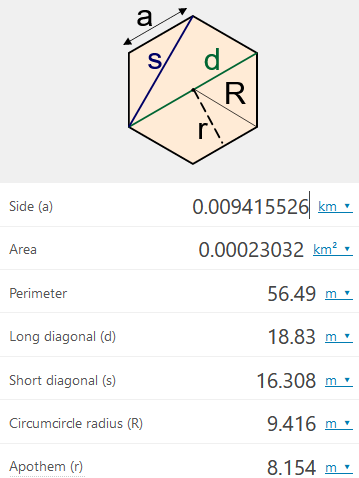

source: https://www.omnicalculator.com/math/hexagon

see https://h3geo.org/docs/core-library/restable/ for hex resolutions and dimensions

In [9]:
def _compute_apothem(edge_length, no_edges):
    return edge_length / (2 * np.tan(np.pi / 6))

def _k_dist_from_metric(apperture, bands, apothem):
    bands = np.array(bands)
    
    k_bands = np.sort(bands // (2 * apothem)).astype(int)
    
    if k_bands[0] == 0:
        k_bands = [1, 2, 5]
        print("Hexagons are to big for distance ranges in 'bands'!\n",
              "Returning results for 1st, 2nd and 5th order contiguity neighbors.")
    
    
    return k_bands


def get_neighbors(gdf, hex_res, bands):
    #TO DO: remove redundancy in edge computation
    edge_length = h3.edge_length(hex_res, unit='m')
    apot = _compute_apothem(edge_length,
                            no_edges=6)
    
    k_bands =  _k_dist_from_metric(hex_res,
                                   bands,
                                   apot)
    
    neighbors = {}
    neighborhood_limit = max(k_bands)
    labels = gdf.index.drop_duplicates()
    for label in labels:
        all_ranges = h3.hex_range_distances(label,
                                            neighborhood_limit)
        
        neighbors_by_band = {}
        for i, k in enumerate(k_bands):
            outer_k = k
            
            if i == 0:
                inner_k = i
            else:
                inner_k = k_bands[i - 1]
                
            neighbors_by_band[f'band_{i + 1}'] = (all_ranges[outer_k]
                                                  - all_ranges[inner_k])
            
        neighbors[label] = neighbors_by_band
        
    return pd.DataFrame.from_dict(neighbors, orient='index')


In [10]:
bands = [100, 200, 500]

neighbors = get_neighbors(hexes,
                          map_res,
                          bands)

In [11]:
def _get_use_correspondence(lu_maps, t0, t1):
    base_map = lu_maps.loc[lu_maps.year==t0, 'use']
    future_map = lu_maps.loc[lu_maps.year==t1, 'use']
    
    
    return (pd.concat([base_map, future_map],
                      keys=[t0, t1],
                      axis=1))


def _get_contingency_table(use_corresp, lu_cats, t0, t1):
    mask = use_corresp[t1].isin(lu_cats)
    
    
    return (use_corresp.groupby([t0, t1])
                       .apply(len)
                       .unstack())


In [12]:
def _compute_inertia(df, lu_cats):
    ir = {}
    for each in df.columns:
        numerator = df.loc[each, each]        
        denominator = df.loc[each, :].sum()
        
        ir[each] = numerator / denominator
        
    ir = pd.DataFrame.from_dict(ir,
                                orient='index',
                                columns=['inertia_rate'],)
        
    return ir * 100


def _compute_conversion(df, lu_cats):
    cr = {}
    for each in df.columns:
        col_mask = (df.columns != each)
        
        numerator = df.loc[each, col_mask]
        denominator = df.loc[:, col_mask].sum()
        
        rates = numerator / denominator
        
        # Note that this creates a as nested dictionary.
        # Each key contains a dictionary of convertion rates,
        # so that the convertion rates from use k to use l can
        # be accessed as # cr[k][l].        
        cr[each] = rates.to_dict()
        
    cr = pd.DataFrame.from_dict(cr,
                                orient='index')
    
    
    return cr * 100


In [13]:
def _get_absolute_neighbor_rep(use_corresp, neighbors, t0, t1):
    
    abs_neighbor_rep = []
    for hex_label in use_corresp.index:
        labels_of_neighbor_hexes = neighbors.loc[hex_label, 'band_1']

        mask = use_corresp.index.isin(labels_of_neighbor_hexes)
        past_neighborhood = (use_corresp.loc[mask, t0]
                                        .value_counts())
        past_neighborhood.name = hex_label

        abs_neighbor_rep.append(past_neighborhood)

    abs_neighbor_rep = pd.concat(abs_neighbor_rep,
                                 axis=1)
    
    
    return abs_neighbor_rep.T


def _get_relative_neighbor_rep(abs_neighbor_rep):
    return abs_neighbor_rep.apply(lambda x: x / x.sum(), axis=1)


def _get_average_neighbor_rep(df, t1):
    def _perform_average(group):
        return group.iloc[:, 1:].sum() / len(group)
    
    return (df.groupby(t1)
              .apply(_perform_average))


def _get_enrichment_factors(mean_neighbor_rep, use_corresp,
                            lu_cats, t0, t1):
    total_cells = len(use_corresp)
    cells_by_use = use_corresp.loc[:, t0].value_counts()
    enrichment =  np.log10(mean_neighbor_rep
                           * total_cells
                           / cells_by_use)
    
    # Land uses are stored as pd.Categorical, thus enrichment
    # comes with all categories becaus value counts counts
    # all categories, regardless if they appear or not.
    enrichment = enrichment.filter(items=lu_cats, axis=0)
    
    
    return enrichment


def _get_cross_influence(df, use_corresp, lu_cats, t0, t1):
    transitions = df.loc[df[t0] != df[t1]]
    transitions.drop(columns=t0, inplace=True)
    mean_neighbor_rep = _get_average_neighbor_rep(transitions, t1)
    
    ci = _get_enrichment_factors(mean_neighbor_rep, use_corresp,
                                 lu_cats, t0, t1)
    
    for col in ci:
        for idx in ci.index:
            if col == idx:
                ci.loc[idx, col] = np.nan
    
    
    return ci


def _get_self_influence(df, use_corresp, lu_cats, t0, t1):
    permanences = df.loc[df[t0] == df[t1]]
    permanences.drop(columns=t0, inplace=True)
    mean_neighbor_rep = _get_average_neighbor_rep(permanences, t1)
    
    si = _get_enrichment_factors(mean_neighbor_rep, use_corresp,
                                 lu_cats, t0, t1)
    
    for col in si:
        for idx in si.index:
            if col != idx:
                si.loc[idx, col] = np.nan
    
    
    return si.sum(axis=1)


def _get_influence_tails(use_corresp, neighbors,
                         lu_cats, t0, t1):
    abs_neighbor_rep = _get_absolute_neighbor_rep(use_corresp,
                                                  neighbors,
                                                  t0,
                                                  t1)
    
    rel_neighbor_rep = _get_relative_neighbor_rep(abs_neighbor_rep)
    
    # TO DO: think on a suitable name for df
    df = use_corresp.merge(rel_neighbor_rep,
                           how='left',
                           left_index=True,
                           right_index=True,)

    df = df.loc[df[t1].isin(lu_cats)]
    
    ci = _get_cross_influence(df, use_corresp, lu_cats, t0, t1)
    si = _get_self_influence(df, use_corresp, lu_cats, t0, t1)
    
    
    return si, ci, use_corresp.merge(abs_neighbor_rep, how='left',
                                     left_index=True, right_index=True,)


In [14]:
def get_empiricals(lu_maps, lu_cats, neighbors, t0, t1):
    t0 = f'{t0}'
    t1 = f'{t1}'
    
    use_corresp = _get_use_correspondence(lu_maps, t0, t1)

    contingency = _get_contingency_table(use_corresp, lu_cats, t0, t1)
    
    inertias = _compute_inertia(contingency, lu_cats)
    
    conversions = _compute_conversion(contingency, lu_cats)
    
    si, ci, abs_rep = _get_influence_tails(use_corresp, neighbors,
                                           lu_cats, t0, t1)
    
    
    return inertias, conversions, si, ci, abs_rep


In [15]:
modeled_cats = ['residential', 'subnormal',
                'retail/services', 'mixed', 'vacant']

with pd.option_context('mode.chained_assignment', None):
    # TO DO: find the bloody trigger for the warning
    ir, cr, si, ci, abs_rep = get_empiricals(hexes,
                                             modeled_cats,
                                             neighbors,
                                             2011,
                                             2017)

# Significances

In [16]:
def apply_mann_whitney(use_counts, modeled_cats, t0, t1):
    
    melted_counts = use_counts.melt(id_vars=[t0, t1],
                                    value_vars=use_counts.columns[2:],
                                    var_name='neighbors',
                                    value_name='counts')
    
    mask = (melted_counts[t1].isin(modeled_cats)
            & (melted_counts[t1] != melted_counts[t0]))
    counts_of_interest = melted_counts.loc[mask]
    
    possible_influences = (counts_of_interest.neighbors
                                             .unique())
    
    distributions = {}
    for (use, neigh), group in counts_of_interest.groupby([t1, 'neighbors']):
        if use != neigh:
            for_transitioned = (group.counts
                                     .to_numpy())

            mask = (melted_counts.neighbors == neigh)
            for_all_cells = (melted_counts.loc[mask]
                                          .counts
                                          .to_numpy())

            _, pnorm = mannwhitneyu(for_transitioned,
                                    for_all_cells,
                                    alternative='two-sided',
                                    method='asymptotic',)


            distributions[(use, neigh)] = pnorm
            
    return distributions


In [17]:
def _get_freq_tallys(counts):
    freq = counts.value_counts()
    return freq / freq.sum()

def apply_mann_whitney(use_counts, modeled_cats, t0, t1):
    
    melted_counts = use_counts.melt(id_vars=[t0, t1],
                                    value_vars=use_counts.columns[2:],
                                    var_name='neighbors',
                                    value_name='counts')
    
    mask = (melted_counts[t1].isin(modeled_cats)
            & (melted_counts[t1] != melted_counts[t0]))
    counts_of_interest = melted_counts.loc[mask]
    
    p_values = {}
    for use, outer_group in counts_of_interest.groupby(t1):
        p_values[use] = {}
        for neigh, inner_group in outer_group.groupby('neighbors'):
            # We are interested only in the cross-influence
            if neigh != use:
                for_transitioned = _get_freq_tallys(inner_group.counts)

                mask = (melted_counts.neighbors == neigh)
                for_all_cells = _get_freq_tallys(melted_counts.loc[mask]
                                                              .counts)

                _, pnorm = mannwhitneyu(for_transitioned.to_numpy(),
                                        for_all_cells.to_numpy(),
                                        alternative='two-sided',
                                        method='asymptotic',)


                p_values[use][neigh] = pnorm
            
    return pd.DataFrame.from_dict(p_values, orient='index')

In [18]:
mann_whit_test = apply_mann_whitney(abs_rep, modeled_cats, '2011', '2017')

mann_whit_test 

,amenities,industry,infrastructure,mixed,public services,retail/services,subnormal,vacant,residential
residential,0.959101,0.644186,0.357097,0.153451,0.789325,0.605274,0.925865,0.051329,NaN
subnormal,0.019976,0.002554,0.005457,0.059447,0.015229,0.064700,NaN,0.586902,0.772011
retail/services,0.441678,0.000271,0.304481,0.162690,0.353830,NaN,0.150962,0.355967,0.719568
mixed,0.971115,0.328801,0.003427,NaN,0.328233,0.719614,0.411764,0.218409,0.136900
vacant,0.100792,0.000271,0.226418,0.104532,0.018326,0.504912,0.643774,NaN,0.959101


In [ ]:
f, ax = plt.subplots(figsize=(20, 4))

trans = df.loc[df['2017'] == 'residential']
sns.kdeplot(ax=ax, data=trans, x='count', hue='use')

sns.kdeplot(ax=ax, data=trans.loc[(trans.switch==1)], x='count', hue='use')

In [ ]:
trans

In [ ]:
def _apply_mann_whitney():
    

def assess_statistical_significance()

In [ ]:
def _force_table_order(df, lu_cats):
    df.index = pd.Categorical(df.index,
                              categories=lu_cats,
                              ordered=True)
    df.sort_index(inplace=True)
    
    if df.shape[1] > 1:
        cats = ['residential', 'subnormal', 'retail/services', 'mixed',
                'vacant', 'amenities', 'public services', 'industry', 'infrastructure']
        
        
        df.columns = pd.Categorical(df.columns,
                                    categories=lu_cats,
                                    ordered=True)
        
        
    return df.sort_index(axis='columns')

In [ ]:
labels_of_neighbor_hexes = neighbors.loc['89a881a4867ffff', 'band_1']

mask = df.index.isin(labels_of_neighbor_hexes)
past_neighborhood = (df.loc[mask, '2011']
                       .value_counts())

past_neighborhood

In [ ]:
past_neighborhood.name = hex_label

abs_neighbor_rep.append(past_neighborhood)

In [ ]:
ci

In [ ]:
abs_neighbor_rep = []
for hex_label in df.index:
    labels_of_neighbor_hexes = neighbors.loc[hex_label, 'band_1']

    mask = df.index.isin(labels_of_neighbor_hexes)
    past_neighborhood = (df.loc[mask, '2011']
                           .value_counts())
    past_neighborhood.name = hex_label

    abs_neighbor_rep.append(past_neighborhood)

abs_neighbor_rep = pd.concat(abs_neighbor_rep,
                             axis=1)

In [ ]:
abs_neighbor_rep.T

In [ ]:
abs_rep.groupby('2017').sum()

In [ ]:
tails['cross_inf']['abs_rep']

In [ ]:
neighbors

In [ ]:
f, ax = plt.subplots()


df = hexes.loc[hexes.index == '8aa88cd9d427fff']
df.plot(ax=ax, color='red')

df = hexes.loc[hexes.index.isin(neighbors.loc['8aa88cd9d427fff', 'band_1'])]
df.plot(ax=ax, color='blue')

In [ ]:
df.loc[df.year == '2011']